# How to define continuous analytical Hamiltonians
**Use analytical expressions to construct your Hamiltonian**

The Boulder Opal [optimization](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) and [simulation](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/execute_graph) engines can be applied to a wide range of quantum systems thanks to the flexible [dataflow graph framework](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal).

In particular, you can define analytical Hamiltonians by taking advantage of Bouldar Opal's basic mathematical operations.
In this notebook we show how to define signals from their analytical expressions and use them for simulation or optimization.
Note that the `signals` attribute in the Boulder Opal graph contains [a library of predefined analytical signals](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#signals) as piecewise-constant ([PWC](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Pwc)) or sampleable ([STF](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Stf)) functions that you can directly use without having to define them from the ground up.
For more information, you can also read the [How to create analytical signals for simulation and optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-create-analytical-signals-for-simulation-and-optimization) user guide.

## Summary workflow

### 1. Create an identity Stf node and define analytical signals

Once a graph has been set up to describe the computation, use the `graph.identity_stf` operation to create an STF representing the identity function $f(t) = t$.

Apply a sequence of [mathematical functions](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes#mathematical-functions) to the identity function to create STF nodes representing your desired signals.

### 2. Construct the Hamiltonian

Create the Hamiltonian terms by multiplying the signals by the appropriate operators.
You can directly use STF nodes created this way with operations such as `graph.time_evolution_operators_stf` or `graph.infidelity_stf`, or you can discretize them into PWCs with `graph.discretize_stf`.
For more information on STFs and PWCs, see the [Working with time-dependent functions in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/working-with-time-dependent-functions-in-boulder-opal) topic.

### 3. Execute the graph for the simulation/optimization
With the graph object created, a simulation can be run using the `boulderopal.execute_graph` function. The outputs and the graph must be provided. The function returns the results of the simulation. 

Alternatively, an optimization can be run using the `boulderopal.run_optimization` function or the `boulderopal.run_stochastic_optimization` function. The cost, the outputs, and the graph must be provided. The function returns the results of the optimization. 

## Example: Simulation with analytical signals 

In this example, we will simulate a Landau–Zener transition in a two-level system.

The Hamiltonian for the system is 
$$
H(t) = \Omega(t) \sigma_x + \Delta(t) \sigma_z ,
$$
where $\Omega(t)$ is the Rabi coupling and $\Delta(t)$ is the detuning.

For the Rabi coupling we will implement a pulse of the form
$$
\Omega(t) = \Omega_0 \sin^2 (\pi t / T) ,
$$
and for the detuning a sweep of the form
$$
\Delta(t) = - \Delta_0 \cos(\pi t / T) ,
$$
where $\Omega_0$ and $\Delta_0$ are the maximum values of the Rabi coupling and detuning,
and $T$ is the signal duration.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

Your task (action_id="1829420") has started.
Your task (action_id="1829420") has completed.


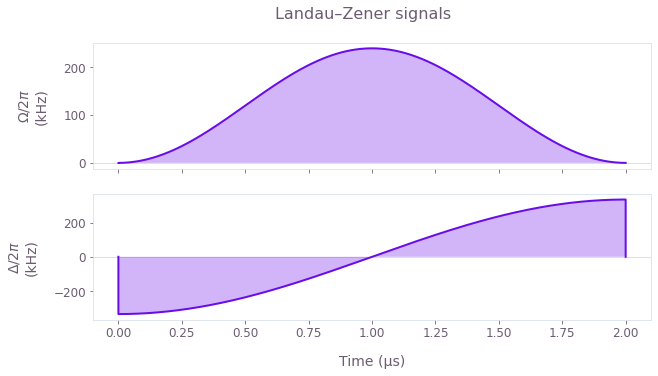

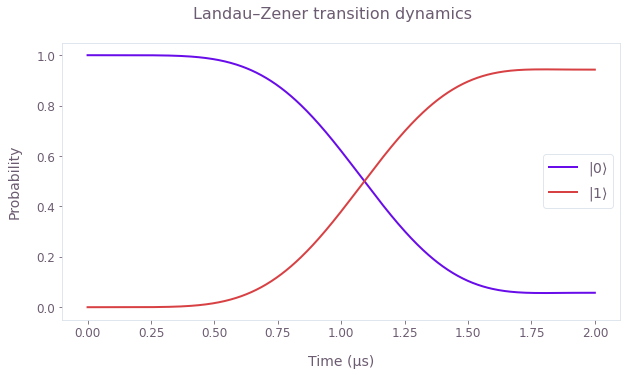

In [2]:
# Create the data flow graph describing the system.
graph = bo.Graph()

# Define the duration of the signals.
duration = 2e-6  # s

# Define the number of samples for the discretizations.
sample_count = 512
sample_times = np.linspace(0.0, duration, sample_count)

# Define maximum values for the signals.
omega_max = 1.5e6  # rad/s
delta_max = 2.1e6  # rad/s

# Define the signals.
t = graph.identity_stf()
omega = omega_max * graph.sin(np.pi * t / duration) ** 2
delta = -delta_max * graph.cos(np.pi * t / duration)

# Construct the Hamiltonian.
hamiltonian = omega * graph.pauli_matrix("X") + delta * graph.pauli_matrix("Z")

# Compute the time-evolution unitaries.
unitaries = graph.time_evolution_operators_stf(
    hamiltonian=hamiltonian, sample_times=sample_times
)

# Define the initial state.
initial_state = graph.fock_state(2, 0)[:, None]

# Evolve the initial state with the unitary to get the final state.
evolved_states = unitaries @ initial_state
evolved_states.name = "states"

# Discretize the signals as STFs can't be directly exported.
graph.discretize_stf(omega, duration, sample_count, name=r"$\Omega$")
graph.discretize_stf(delta, duration, sample_count, name=r"$\Delta$")

# Run simulation.
result = bo.execute_graph(
    graph=graph, output_node_names=["states", r"$\Omega$", r"$\Delta$"]
)

# Plot the analytical signals used.
qv.plot_controls(
    {name: result["output"][name] for name in [r"$\Omega$", r"$\Delta$"]}, smooth=True
)
plt.suptitle("Landau–Zener signals")

# Plot the population dynamics.
populations = np.abs(result["output"]["states"]["value"].squeeze()) ** 2
qv.plot_population_dynamics(
    sample_times, {rf"$|{k}\rangle$": populations[:, k] for k in range(2)}
)
plt.suptitle("Landau–Zener transition dynamics")
plt.show()

## Example: Optimization with analytical signals 

In this example, we will implement an X gate in a noisy single-qubit system, by optimizing the parameters of two signals. 

The Hamiltonian for the system is 
$$
H(t) = \alpha(t) \sigma_{z} + \frac{1}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \delta \sigma_{z} + \zeta(t) \sigma_{z} , 
$$
where $\alpha(t)$ and $\gamma(t)$ are signals with optimizable parameters, $\delta$ is the qubit detuning, and $\zeta(t)$ is a dephasing noise process.

The $\alpha(t)$ signals acting on $\sigma_{z}$ is an arctangent ramp, defined by
$$
\alpha(t) = \alpha_0 \arctan\left( \frac{t - t_0}{t_\mathrm{ramp}} \right)  ,
$$
where $\pm a_0$ are the asymptotic values of the signal, $t_0$ is the center time, and $t_\mathrm{ramp}$ is the characteristic duration of the ramp.

The $\gamma(t)$ signal acting on $\sigma_{-}$ is a Gaussian signal, defined by
$$
\gamma(t) = \gamma_0 \exp \left(- \frac{(t-t_0)^2}{2\sigma^2} \right)  ,
$$
where $\gamma_0$ is the amplitude, 
$\sigma$ is the width of the Gaussian, and
$t_0$ is the center of the signal.


We will fix the characteristic ramp time $t_\mathrm{ramp}$ and Gaussian width $\sigma$, and aim to find optimal values for the rest of signal parameters to implement the target quantum gate.

In this case, we will discretize the smooth analytical signals into [piecewise-constant functions](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Pwc) to simulate a discrete interface with an experiment.

Your task (action_id="1829421") has started.
Your task (action_id="1829421") has completed.
Optimized cost: 6.748e-04
Optimal signal parameters
	α(t) amplitude:	-3.943e+06 rad/s
	α(t) center:	1.317e-06 s
	γ(t) amplitude:	-1.729e+06-6.041e+06j rad/s
	γ(t) center:	1.431e-06 s


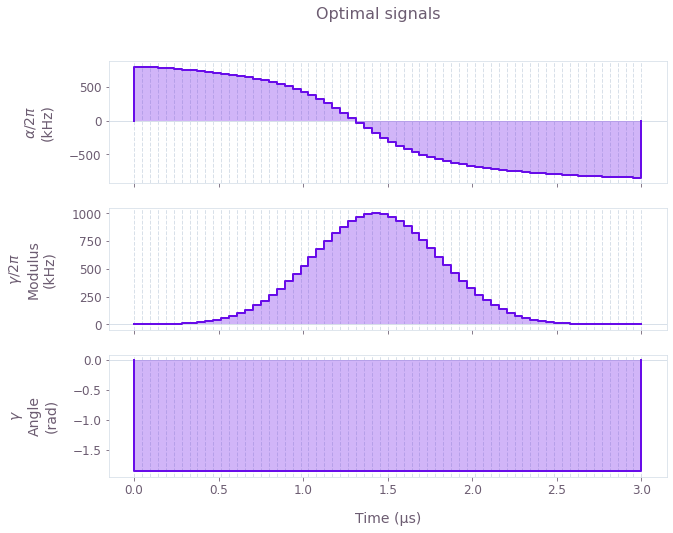

In [3]:
graph = bo.Graph()

# Define the duration of the signals.
duration = 3e-6  # s
sample_count = 64

# Define α(t) as an arctan ramp.
t = graph.identity_stf()
alpha_ramp = duration / 8
alpha_zero = graph.optimizable_scalar(
    lower_bound=-3e7, upper_bound=3e7, name="alpha_amplitude"
)
alpha_center = graph.optimizable_scalar(
    lower_bound=0.0, upper_bound=duration, name="alpha_center"
)
alpha_stf = alpha_zero * graph.arctan((t - alpha_center) / alpha_ramp)

# Define γ(t) as a Gaussian pulse.
gamma_max = 2.0 * np.pi * 1e6
gamma_width = duration / 8
gamma_modulus = graph.optimizable_scalar(lower_bound=-gamma_max, upper_bound=gamma_max)
gamma_phase = graph.optimizable_scalar(
    lower_bound=0,
    upper_bound=2.0 * np.pi,
    is_lower_unbounded=False,
    is_upper_unbounded=False,
)
gamma_amplitude = gamma_modulus * graph.exp(1j * gamma_phase)
gamma_amplitude.name = "gamma_amplitude"

gamma_center_time = graph.optimizable_scalar(
    lower_bound=0.0, upper_bound=duration, name="gamma_center"
)
gamma_stf = graph.signals.gaussian_pulse_stf(
    gamma_amplitude, gamma_width, gamma_center_time
)

# Discretize the signals.
alpha = graph.discretize_stf(alpha_stf, duration, sample_count, name=r"$\alpha$")
gamma = graph.discretize_stf(gamma_stf, duration, sample_count, name=r"$\gamma$")

# Create Hamiltonian.
hamiltonian = alpha * graph.pauli_matrix("Z") + graph.hermitian_part(
    gamma * graph.pauli_matrix("M")
)

# Add detuning term.
delta = 2 * np.pi * 0.25e6  # rad/s
hamiltonian += delta * graph.pauli_matrix("Z")

# Define target gate.
target = graph.target(operator=graph.pauli_matrix("X"))

# Add dephasing noise term.
zeta = 2 * np.pi * 20e3  # rad/s
dephasing = zeta * graph.pauli_matrix("Z")

# Robust infidelity.
robust_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    noise_operators=[dephasing],
    target=target,
    name="robust_infidelity",
)

result = bo.run_optimization(
    graph=graph,
    cost_node_name="robust_infidelity",
    output_node_names=[
        "alpha_amplitude",
        "alpha_center",
        "gamma_amplitude",
        "gamma_center",
        r"$\alpha$",
        r"$\gamma$",
    ],
    optimization_count=8,
)

print(f"Optimized cost: {result['cost']:.3e}")

# Print out the converged signal parameters.
print("Optimal signal parameters")
print(f"\tα(t) amplitude:\t{result['output']['alpha_amplitude']['value']:.3e} rad/s")
print(f"\tα(t) center:\t{result['output']['alpha_center']['value']:.3e} s")
print(f"\tγ(t) amplitude:\t{result['output']['gamma_amplitude']['value']:.3e} rad/s")
print(f"\tγ(t) center:\t{result['output']['gamma_center']['value']:.3e} s")

# Plot the optimal analytical signals found.
qv.plot_controls({name: result["output"][name] for name in [r"$\alpha$", r"$\gamma$"]})
plt.suptitle("Optimal signals")
plt.show()